# Analysis of DeepPath Experiments
This notebook documents our analysis of performance results from various experiments ran on DeepPath models

In [1]:
# Packages/Helper Function Import
from pathlib import Path
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import deeppath_parsers as dp
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

In [2]:
# Directory Constants
output_dir = Path("work/output/")

In [3]:
# Helper function for loading many studies
def load_studies(studies,labels):
    # Parse slide probs
    slide_probs = pd.concat({
        study.stem:pd.DataFrame(dp.parse_slide_probs(study / "auc" / "out2_perSlideStats.txt"))
        for study in studies
    },names=["study"]).reset_index("study")
    slide_probs["group"] = slide_probs["study"].str.extract(r".*_(.*)_.*",expand=False).str.capitalize()
    slide_probs["group"].fillna("Control",inplace=True)
    slide_probs["study"] = pd.Categorical(slide_probs["study"].apply(lambda x: labels[x]),categories=list(labels.values()),ordered=True)
    slide_probs.sort_values(["study","class"],inplace=True)
    slide_probs["study"] = slide_probs["study"].astype(str)
    # Parse tile probs
    tile_probs =  pd.concat({
        study.stem:pd.DataFrame(dp.parse_tile_probs(study / "out_filename_Stats.txt"))
        for study in studies
    },names=["study"]).reset_index("study")
    tile_probs["group"] = tile_probs["study"].str.extract(r".*_(.*)_.*",expand=False).str.capitalize()
    tile_probs["group"].fillna("Control",inplace=True)
    tile_probs["study"] = pd.Categorical(tile_probs["study"].apply(lambda x: labels[x]),categories=list(labels.values()),ordered=True)
    tile_probs.sort_values(["study","class"],inplace=True)
    tile_probs["study"] = tile_probs["study"].astype(str)
    #Parse AUCs
    auc = pd.concat({
        study.stem:pd.DataFrame(dp.parse_auc_file(study / "auc_summary.txt"))
        for study in studies
    },names=["study"]).reset_index()
    auc["group"] = auc["study"].str.extract(r".*_(.*)_.*",expand=False).str.capitalize()
    auc["group"].fillna("Control",inplace=True)
    auc["study"] =pd.Categorical(auc["study"].apply(lambda x: labels[x]),categories=list(labels.values()),ordered=True)
    auc.sort_values(["study","class"],inplace=True)
    auc["study"] = auc["study"].astype(str)
    auc["ci_upper"] = auc["ci_upper"] - auc["auc"]
    auc["ci_lower"] = auc["auc"] - auc["ci_lower"]
    slide_auc = auc[auc.type=="slide"]
    tile_auc = auc[auc.type=="tile"]
    return slide_probs,tile_probs,slide_auc,tile_auc
# Helper function for plotting with error bars
# Adapted from : https://stackoverflow.com/questions/45875143/seaborn-making-barplot-by-group-with-asymmetrical-custom-error-bars
def auc_error_bar_plot(x,y,hue,lb,ub,label_order,**kwargs):
    data = kwargs.pop("data")
    # from https://stackoverflow.com/a/37139647/4124317
    errLo = data.pivot(index=x, columns=hue, values=lb)
    errHi = data.pivot(index=x, columns=hue, values=ub)
    err = []
    for col in errLo:
        err.append([errLo[col].values, errHi[col].values])
    err = np.abs(err)
    p = data.pivot(index=x, columns=hue, values=y)
    p = p.reindex(label_order).dropna(axis=0)
    fig = p.plot(kind='bar',yerr=err,ax=plt.gca(), **kwargs)
    return fig

## Phase 1 Analyses
Phase 1 analyses the failure modes of the model by pertubing input datasets in various ways

In [4]:
# Phase 1 Study Labels
phase1_labels = {
    "exp_bubbles_20": "B 20%",
    "exp_bubbles_100": "B 100%",
    "exp_fold_20": "F 20%",
    "exp_illumination_10": "I 10%",
    "exp_illumination_50": "I 50%",
    "exp_illumination_100": "I 100%",
    "exp_marker_50": "M 50%",
    "exp_marker_90": "M 90%",
    "exp_sectioning_15": "Se 15%",
    "exp_sectioning_30" : "Se 30%",
    "exp_stain_10": "St 10%",
    "exp_stain_30": "St 30%",
    "exp_tear_15": "T 15",
    "all": "Unperturbed"
}

phase1_studies = list(output_dir.glob("exp_*_*")) + [output_dir / "all"]
phase1_slide_probs, phase1_tile_probs, phase1_slide_auc, phase1_tile_auc = load_studies(phase1_studies,phase1_labels)

Text(0.5, 0.98, 'Phase 1: Slide Average True Probabilities')

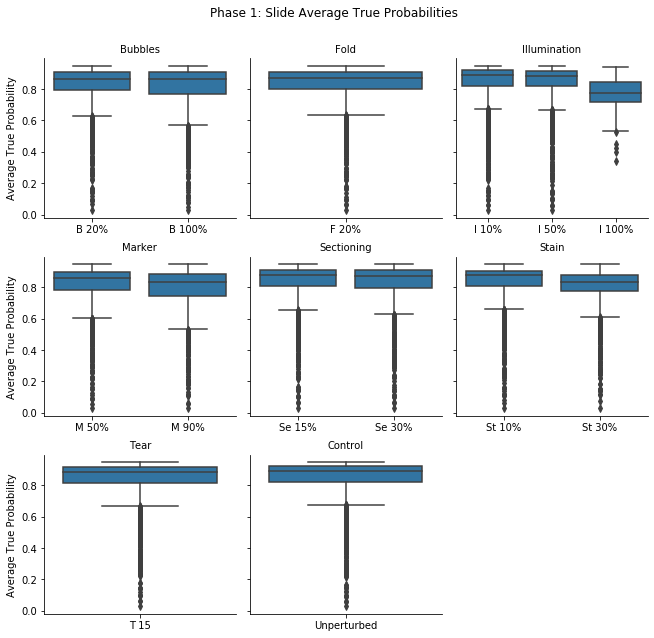

In [5]:
# Average True Prob Overall
g = sns.FacetGrid(data=phase1_slide_probs,col="group",sharex=False,col_wrap=3)
g.map_dataframe(sns.boxplot,x="study",y="true_av_prob")
g.set_titles("{col_name}")
g.set_ylabels("Average True Probability")
plt.subplots_adjust(top=0.9)
plt.suptitle("Phase 1: Slide Average True Probabilities")

Text(0.5, 0.98, 'Phase 1: Slide Average True Probabilities (By Class)')

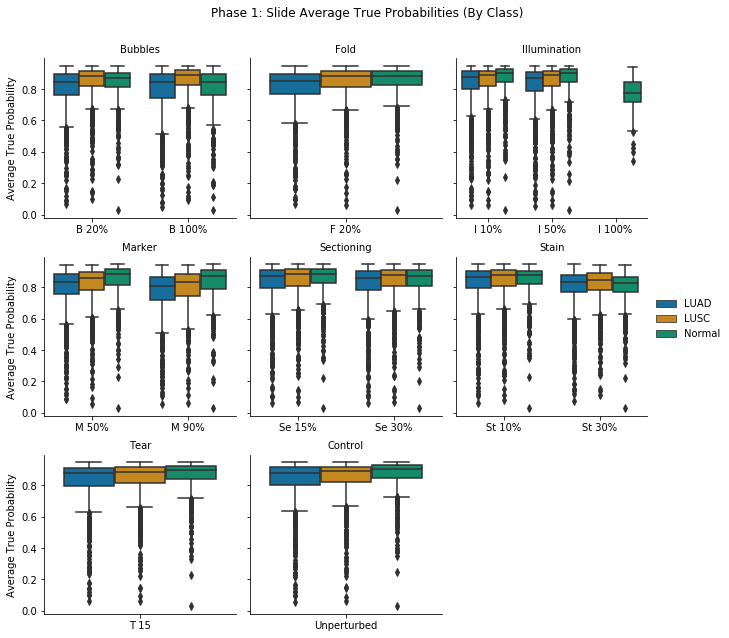

In [6]:
g = sns.FacetGrid(data=phase1_slide_probs,col="group",sharex=False,col_wrap=3)
g.map_dataframe(sns.boxplot,x="study",y="true_av_prob",hue="class",palette="colorblind")
g.add_legend()
g.set_titles("{col_name}")
g.set_ylabels("Average True Probability")
plt.subplots_adjust(top=0.9)
plt.suptitle("Phase 1: Slide Average True Probabilities (By Class)")

Text(0.5, 0.98, 'Phase 1: Tile True Probabilities (By Class)')

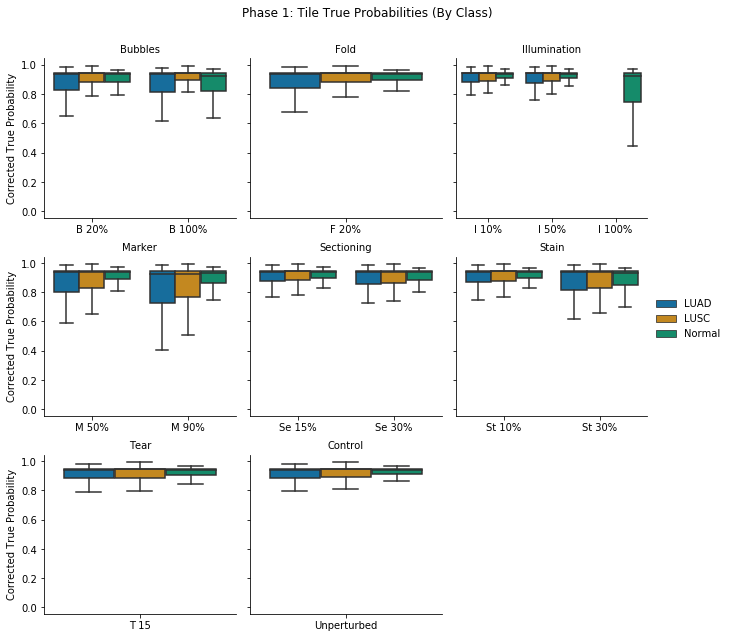

In [7]:
g = sns.FacetGrid(data=phase1_tile_probs,col="group",sharex=False,col_wrap=3)
g.map_dataframe(sns.boxplot,x="study",y="corrected_true_prob",hue="class",palette="colorblind",fliersize=0.001)
g.add_legend()
g.set_titles("{col_name}")
g.set_ylabels("Corrected True Probability")
plt.subplots_adjust(top=0.9)
plt.suptitle("Phase 1: Tile True Probabilities (By Class)")

ValueError: Index contains duplicate entries, cannot reshape

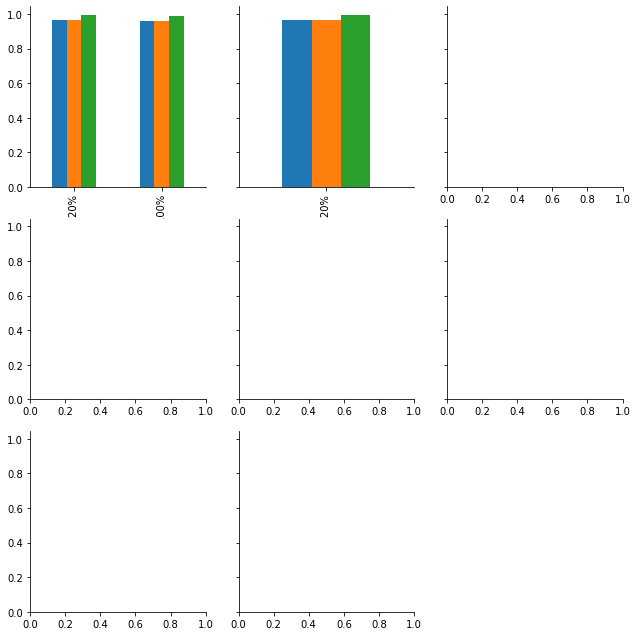

In [8]:
g = sns.FacetGrid(phase1_tile_auc, col="group",sharex=False,col_wrap=3) 
g.map_dataframe(auc_error_bar_plot, x="study", y="auc", hue="class", lb="ci_lower", ub="ci_upper",label_order=phase1_labels.values(),color=sns.color_palette()[0:3]) 
g.add_legend()
g.set_titles("{col_name}")
g.set_ylabels("AUC")
g.set_xlabels("")
plt.subplots_adjust(top=0.9)
plt.suptitle("Phase 1: AUC By Tile")

In [ ]:
g = sns.FacetGrid(data=phase1_slide_auc,col="group",sharex=False,col_wrap=3)
g.map_dataframe(auc_error_bar_plot, x="study", y="auc", hue="class", lb="ci_lower", ub="ci_upper",label_order=phase1_labels.values(),color=sns.color_palette()[0:3]) 
g.add_legend()
g.set_titles("{col_name}")
g.set_ylabels("AUC")
g.set_xlabels("")
plt.subplots_adjust(top=0.9)
plt.suptitle("Phase 1: AUC By Slide")

In [ ]:
def threshold_analysis(probs,auc):
# Calculate accuracies depending on threshold
    x = probs[["study","group","class","normal_prob","luad_prob","lusc_prob"]].melt(id_vars=["study","group","class"]).rename(columns=  {"class":"true_class"})
    x["prob_class"] = x["variable"].str[:-5]
    y = auc[["study","class","best_thresh"]]
    y["thresh_class"] = y["class"].str.lower()
    y.drop(columns="class",inplace=True)
    merged = x.merge(y,left_on=["study","prob_class"],right_on=["study","thresh_class"])
    merged["is_class"] = merged["value"] > merged["best_thresh"]
    merged["is_true"] = merged["true_class"].str.lower() == merged["prob_class"]
    study_thresh_acc = merged.groupby(["study","group","true_class"]).apply(lambda x: accuracy_score(y_true=x["is_true"],y_pred=x["is_class"]))
    merged = x.merge(y[y["study"]=="Unperturbed"][["thresh_class","best_thresh"]],left_on=["prob_class"],right_on=["thresh_class"])
    merged["is_class"] = merged["value"] > merged["best_thresh"]
    merged["is_true"] = merged["true_class"].str.lower() == merged["prob_class"]
    ctrl_thresh_acc = merged.groupby(["study","group","true_class"]).apply(lambda x: accuracy_score(y_true=x["is_true"],y_pred=x["is_class"]))
    relative_acc = pd.DataFrame({"study_acc":study_thresh_acc,"ctrl_acc":ctrl_thresh_acc}).reindex(phase1_labels.values(),axis=0,level="study").reset_index()
    relative_acc["delta_acc"] = relative_acc["ctrl_acc"] - relative_acc["study_acc"]
    return relative_acc


In [ ]:
tile_relative_auc = threshold_analysis(phase1_tile_probs,phase1_tile_auc)
g = sns.FacetGrid(tile_relative_auc[tile_relative_auc["group"]!="Control"], col="group",sharex=False,col_wrap=3) 
g.map_dataframe(sns.pointplot,join=False,dodge=True, x="study", y="delta_acc",hue="true_class",palette="colorblind",hue_order=["LUAD","LUSC","Normal"]) 
def plot_0_line(**kwargs):
    plt.axhline(y=0,**kwargs)
g.map(plot_0_line,color="black")
g.add_legend()
g.set_titles("{col_name}")
g.set_ylabels("Change in Accuracy (Control - Study)")
g.set_xlabels("")
plt.subplots_adjust(top=0.9)
plt.suptitle("Phase 1: Change in Tile Accuracy Due to Threshold Change")


In [ ]:
slide_relative_acc = threshold_analysis(phase1_slide_probs,phase1_slide_auc)
g = sns.FacetGrid(slide_relative_acc[slide_relative_acc["group"]!="Control"], col="group",sharex=False,col_wrap=3) 
g.map_dataframe(sns.pointplot,join=False,dodge=True, x="study", y="delta_acc",hue="true_class",palette="colorblind",hue_order=["LUAD","LUSC","Normal"]) 
def plot_0_line(**kwargs):
    plt.axhline(y=0,**kwargs)
g.map(plot_0_line,color="black")
g.add_legend()
g.set_titles("{col_name}")
g.set_ylabels("Change in Accuracy (Control - Study)")
g.set_xlabels("")
plt.subplots_adjust(top=0.9)
plt.suptitle("Phase 1: Change in Slide Accuracy Due to Threshold Change")
